## Fun with maps

In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import warnings
import pycountry
from difflib import SequenceMatcher
warnings.filterwarnings('ignore')
sns.set()

def str_similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [2]:
shapefile = 'ne_10m_admin_0_countries/ne_10m_admin_0_countries'

In [3]:
gc = GeonamesCache()
iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

In [4]:
people_3rd = pd.read_excel('peopleKavli2018.xlsx',sheet_name='3rd floor')
people_4th = pd.read_excel('peopleKavli2018.xlsx',sheet_name='4th floor')
people = pd.concat([people_3rd,people_4th])

In [5]:
# Find closest match
country_codes = []
for country in people.Country.values:
    found = False
    for official_codes in list(pycountry.countries):
        if country in official_codes.name:
            found = True
            country_codes.append(official_codes.alpha_3)
            break
        elif str_similarity(official_codes.name, country)>0.8:
            found = True
            country_codes.append(official_codes.alpha_3)
            break
    if not found:
        if 'USA' in country:
            country_codes.append('USA')
        elif 'UK' in country:
            country_codes.append('UK')
        else: 
            country_codes.append('Not found')
    found = False

In [6]:
print('{} people/countries matched.'.format(len(country_codes)))

118 people/countries matched.


In [7]:
people['country_codes'] = country_codes

In [8]:
df = people.groupby('country_codes').count()

In [9]:
num_colors = df['Country'].values.max() + 1
bins = np.linspace(df['Country'].values.min(), df['Country'].values.max(), num_colors)
values = df['Country']
cm = plt.get_cmap('Reds')
scheme = [cm(i / num_colors) for i in range(num_colors)]

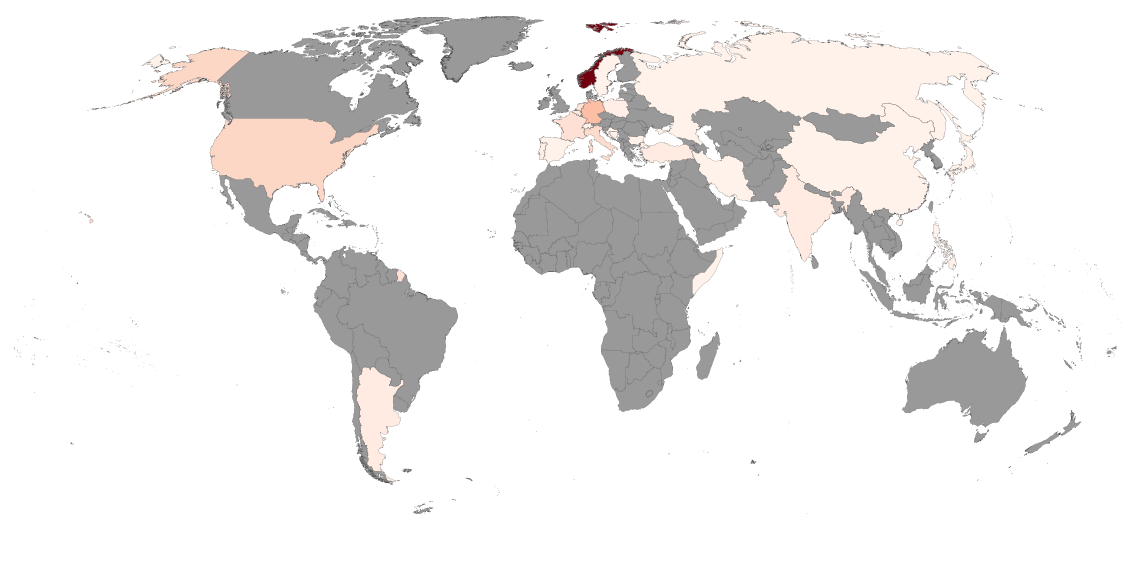

In [10]:
fig = plt.figure(figsize=(20, 18))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w')

m.readshapefile(shapefile, 'units', color='#555555', linewidth=.2)
for info, shape in zip(m.units_info, m.units):
    iso3 = info['ADM0_A3']
    if iso3 not in df.index:
        color = '#999999'
    else:
        color = scheme[df.ix[iso3]['Country']]

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)